In [35]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
# import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from icu_mortality_prediction import DATA_DIR

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING LAB DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file LAB_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


In [3]:
lab_events_filename = 'LAB_EVENTS_FIRST24.csv'
lab_events_filepath = os.path.join(DATA_DIR, 'interim',lab_events_filename)
lab_events_data_df = pd.read_csv(lab_events_filepath) #, index_col = 'icustay_id')

lab_events_data_df.loc[:,'charttime']  = pd.to_datetime(lab_events_data_df.loc[:,'charttime'])
lab_events_data_df = lab_events_data_df.sort_values(['icustay_id', 'charttime'],ascending=True)
lab_events_data_df.head()

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [4]:
print("loading lab data")
lab_events_data_df['subject_id'] = lab_events_data_df.index
lab_events_data_df.set_index(np.arange(lab_events_data_df.shape[0]), inplace = True)
cols = list(lab_events_data_df.columns)
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
lab_events_data_df = lab_events_data_df[cols]
print("complete")

loading lab data
complete


In [5]:
lab_events_data_df2 = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first')
lab_events_data_df3 = lab_events_data_df.drop_duplicates('subject_id', keep = 'first')

print("The number of unique ICU stays = {}".format(lab_events_data_df2.shape[0]))
print("The number of unique patients  = {}".format(lab_events_data_df3.shape[0]))

# display the different measurements captured in the database query
labels = lab_events_data_df.label.unique()
display(lab_events_data_df.shape)
display(lab_events_data_df[(lab_events_data_df.label=='Lactate') & (~(lab_events_data_df.valuenum.isnull()))].head())
display(labels)
display(len(labels))

The number of unique ICU stays = 59798
The number of unique patients  = 943120


(943120, 8)

,icustay_id,subject_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
3,200001,714219,F,Lactate,2181-11-25 19:27:00,1.4,NaN,0
26,200003,482496,M,Lactate,2199-08-03 01:55:00,5.1,abnormal,0
29,200003,482499,M,Lactate,2199-08-03 03:42:00,4.1,abnormal,0
36,200003,488452,M,Lactate,2199-08-03 17:52:00,2.6,abnormal,0
44,200006,204004,M,Lactate,2159-09-03 08:11:00,3.1,abnormal,0


array(['Hematocrit', 'White Blood Cells', 'pH', 'Lactate', 'Creatinine',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Oxygen Saturation',
       'Creatinine, Urine', '24 hr Creatinine', 'Urine Creatinine',
       'WBC Count'], dtype=object)

12

## REMOVING VARIABLES FOR WHICH THERE IS LITTLE DATA

In [6]:
labels

array(['Hematocrit', 'White Blood Cells', 'pH', 'Lactate', 'Creatinine',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Oxygen Saturation',
       'Creatinine, Urine', '24 hr Creatinine', 'Urine Creatinine',
       'WBC Count'], dtype=object)

In [7]:
# REMOVE VARIABLES FOR WHICH THERE IS LITTLE DATA / FEW ICUSTAYS FOR WHICH DATA WAS RECORDED
labels2 = []

for item in labels:
    num_samps = lab_events_data_df['icustay_id'][lab_events_data_df.label == item].dropna().unique().shape[0]
    #num_measures = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    print("{}    {}".format(item, num_samps)) #, num_measures)
    if num_samps > 6000:
        print("adding {}".format(item))
        labels2.append(item)
labels2.sort(key=str.lower)
labels2

Hematocrit    59404
adding Hematocrit
White Blood Cells    59175
adding White Blood Cells
pH    45343
adding pH
Lactate    31261
adding Lactate
Creatinine    52902
adding Creatinine
Glucose    51725
adding Glucose
Lactate Dehydrogenase (LD)    14542
adding Lactate Dehydrogenase (LD)
Oxygen Saturation    19243
adding Oxygen Saturation
Creatinine, Urine    6719
adding Creatinine, Urine
24 hr Creatinine    21
Urine Creatinine    4
WBC Count    173


['Creatinine',
 'Creatinine, Urine',
 'Glucose',
 'Hematocrit',
 'Lactate',
 'Lactate Dehydrogenase (LD)',
 'Oxygen Saturation',
 'pH',
 'White Blood Cells']

## CALCULATE NUMBER OF SAMPLES FOR EACH FEATURE

In [8]:
labels2

['Creatinine',
 'Creatinine, Urine',
 'Glucose',
 'Hematocrit',
 'Lactate',
 'Lactate Dehydrogenase (LD)',
 'Oxygen Saturation',
 'pH',
 'White Blood Cells']

In [9]:
# calculating the number of samples taken in 24 hours for each measurement
item = labels2[0]

num_samps_df =  lab_events_data_df[lab_events_data_df.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
   
for item in labels2[1:]:
    #num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    groupby_counts = lab_events_data_df[lab_events_data_df.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    groupby_counts.columns = [item]
    num_samps_df = num_samps_df.merge(groupby_counts,left_index = True, right_index = True, how = 'left', sort = True) 
    #print "{}    {}".format(item, num_measures) #, num_measures)

#num_samps_df.drop('label', axis=1, inplace = True)
num_samps_df.dropna().head(20)

,label,"Creatinine, Urine",Glucose,Hematocrit,Lactate,Lactate Dehydrogenase (LD),Oxygen Saturation,pH,White Blood Cells
icustay_id,,,,,,,,,
200028,3,1.0,2.0,4.0,8.0,1.0,2.0,16.0,2.0
200075,2,2.0,2.0,2.0,5.0,1.0,3.0,1.0,1.0
200349,5,1.0,5.0,5.0,4.0,1.0,1.0,8.0,5.0
200410,4,1.0,4.0,3.0,4.0,2.0,1.0,3.0,3.0
200726,2,1.0,2.0,2.0,3.0,1.0,1.0,4.0,2.0
200763,4,2.0,4.0,5.0,2.0,2.0,1.0,7.0,4.0
200859,2,2.0,2.0,4.0,5.0,2.0,3.0,9.0,3.0
200908,3,1.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0
200977,2,1.0,1.0,4.0,5.0,1.0,4.0,13.0,3.0


## GENERATE COLORMAPS SHOWING PATTERNS OF MISSING DATA 

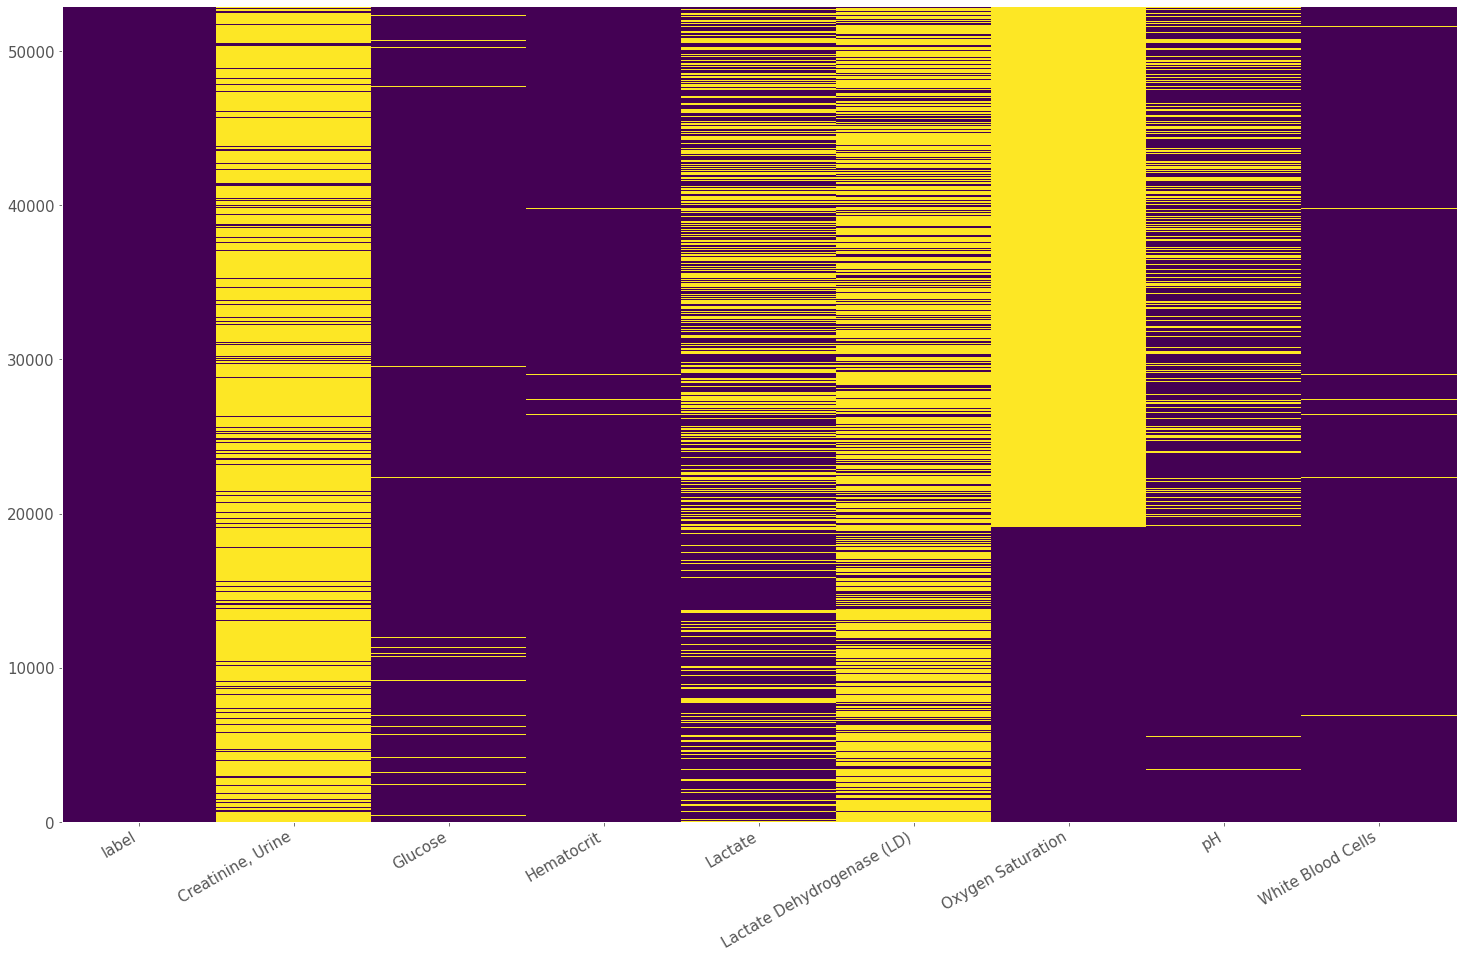

'\n# DISPLAY COLORMAP OF THE NUMBER OF SAMPLES FOR EACH VARIABLE\n#header = num_samps_df.replace(np.nan, -100, inplace = False)\nplt.figure(figsize = (20,30))\nplt.pcolor(num_samps_df.dropna())\nplt.xticks(np.arange(0.5, len(num_samps_df.columns),1), num_samps_df.columns)\nplt.show()\n'

In [10]:
# DISPLAY COLORMAP OF MISSING SAMPLES FOR EACH VARIABLE
# REFERRING TO THIS AS AN AFFINITY MAP, SHOWING WHICH DATA WAS COLLECTED MOST OFTEN TOGETHER. 
# ASSIGNING NaN A NEGATIVE VALUE MAKES MISSING DATA APPEAR DARK BLUE

missing = num_samps_df.copy()

for col in missing.columns:
        missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        

missing = missing.sort_values(by ='Oxygen Saturation', axis = 0, ascending = True)
plt.rc('font', size=15)   
plt.figure(figsize= (25,15))
plt.pcolor(missing)
#ax.set_ylim([0.0,missing.shape[0]])


plt.xticks(np.arange(0.5, len(missing.columns), 1), missing.columns)
plt.xticks(rotation = 30, ha = 'right')

plt.show()
plt.close()

'''
# DISPLAY COLORMAP OF THE NUMBER OF SAMPLES FOR EACH VARIABLE
#header = num_samps_df.replace(np.nan, -100, inplace = False)
plt.figure(figsize = (20,30))
plt.pcolor(num_samps_df.dropna())
plt.xticks(np.arange(0.5, len(num_samps_df.columns),1), num_samps_df.columns)
plt.show()
'''

## Calculating values from original data including mean, std, delta etc. 


In [11]:
labels2

['Creatinine',
 'Creatinine, Urine',
 'Glucose',
 'Hematocrit',
 'Lactate',
 'Lactate Dehydrogenase (LD)',
 'Oxygen Saturation',
 'pH',
 'White Blood Cells']

In [12]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.



# labels2 were sorted alphabetically so we order this list accordingly before zipping
dict_names = ['Creat','CreatUrine', 'Gluc', 'Hemat', 'Lac', 'LacDehyd', 'O2sat', 'pH', 'WBC']

# CREATE DICTS OF VARIABLE NAMES WITH MEASUREMENT INDICATOR APPENDED AS KEYS AND 
# LABELS AS ENTRIES
first_dict_names = dict(zip([item + '_first' for item in dict_names], labels2))
mean_dict_names = dict(zip([item + '_mean' for item in dict_names], labels2))
med_dict_names = dict(zip([item + '_med' for item in dict_names], labels2))
std_dict_names = dict(zip([item + '_std' for item in dict_names], labels2))
skew_dict_names = dict(zip([item + '_skew' for item in dict_names], labels2))
min_dict_names = dict(zip([item + '_min' for item in dict_names], labels2))
max_dict_names = dict(zip([item + '_max' for item in dict_names], labels2))
slope_dict_names = dict(zip([item + '_slope' for item in dict_names], labels2))
delta_dict_names = dict(zip([item + '_delta' for item in dict_names], labels2))
abnflag_dict_names = dict(zip([item + '_abnflag' for item in dict_names], labels2))

# CREATE LIST OF NAMES_DICTS FOR EASY TRAVERSAL / ITERATION AND FOR ZIPPING INTO DICTIONARY
names_list = [first_dict_names, mean_dict_names, med_dict_names, std_dict_names, skew_dict_names, 
              min_dict_names, max_dict_names, slope_dict_names, delta_dict_names, abnflag_dict_names ]
# CREATE LIST FOR ZIPPING INTO DICTIONARY THE MEASUREMENT TYPE AND THE CORRESPONDING NAMES_DICT
calc_list = ['first', 'mean', 'med', 'std', 'skew', 'min', 'max', 'slope', 'delta', 'abnflag']

# CREATE DICTIONARY WHERE KEY IS THE TYPE OF CALCULATION AND THE VALUE IS THE NAMES_DICT 
names_dict = dict(zip(calc_list, names_list))


# CREATE DICTIONARIES IN WHICH TO STORE CALCULATED VALUES
first_dict = {}
mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
kurt_dict = {}
min_dict = {}
max_dict = {}
slope_dict = {}
delta_dict = {}
abnflag_dict = {}
dict_list = [first_dict, mean_dict, med_dict, std_dict, skew_dict, min_dict, max_dict, slope_dict, delta_dict,
            abnflag_dict]
calc_dict = dict(zip(calc_list, dict_list))

# ITERATING THROUGH THE VARIABLES, CALCULATING MEANS, MEDIANS, STD, SKEWNESS, MIN AND MAX'S FOR EACH ITERATION
# VARIABLES WITH TOO FEW MEASUREMENTS TO CALCULATE THINGS LIKE STD WILL BE AUTOMATICALLY ASSIGNED 'NaN' VALUE
print("Creating data frames for each summary statistic for each time course variable")
for calc_key in calc_dict.keys():
    for col_key in names_dict[calc_key].keys(): 
        if calc_key == 'mean':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].mean())
        elif calc_key == 'med':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].median())
        elif calc_key == 'std':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].std())
        elif calc_key == 'max':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].max())
        elif calc_key == 'min':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].min())
        elif calc_key == 'first': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'skew':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].skew())
        elif calc_key == 'delta': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last() -
                                                        lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'abnflag':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['flag'].apply(lambda x: int(1) if 'abnormal' in x.values else int(0)))
              
        elif calc_key == 'slope':
            time_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].last()
            time_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].first()
            val_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last()
            val_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first()
            calc_dict[calc_key][col_key] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))           
        
            
        else: 
            print("need to add code for calculating {}".format(calc_key))
            break
            
        calc_dict[calc_key][col_key].replace([np.inf, -np.inf], np.nan, inplace = True)
        calc_dict[calc_key][col_key].columns = [col_key]
        calc_dict[calc_key][col_key]['hospital_expire_flag'] = lab_events_data_df.groupby('icustay_id').hospital_expire_flag.first()
        calc_dict[calc_key][col_key]['gender'] = lab_events_data_df.groupby('icustay_id').gender.first()

print("complete")

Creating data frames for each summary statistic for each time course variable
complete


## PLOTTING DATA

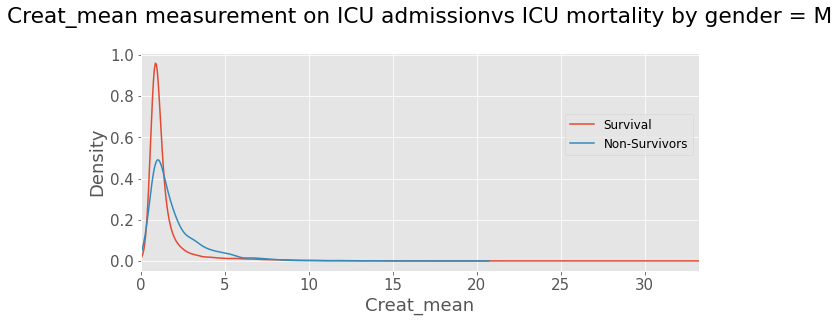

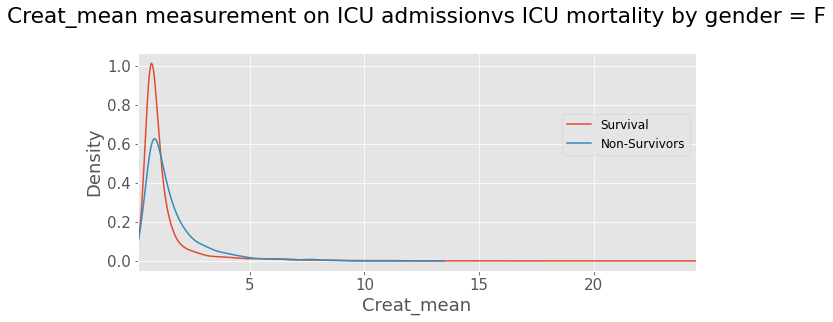

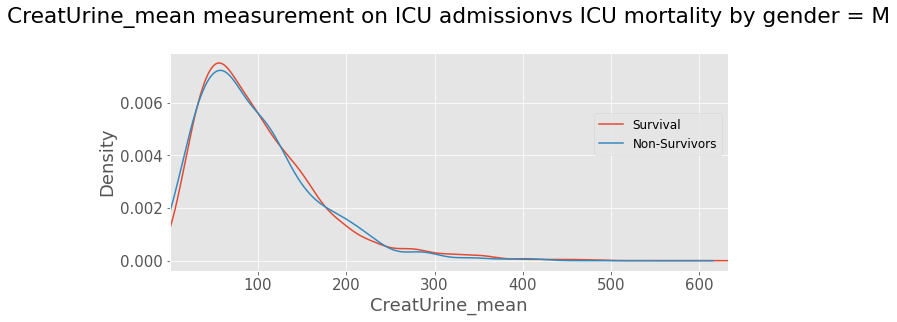

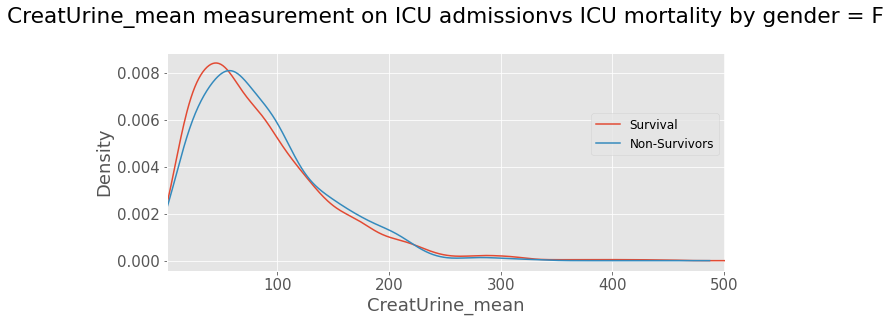

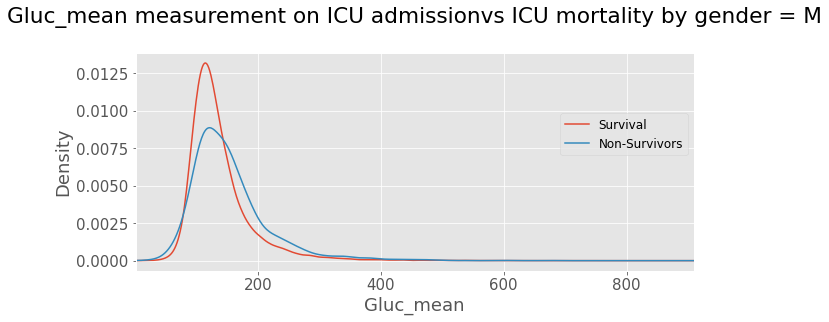

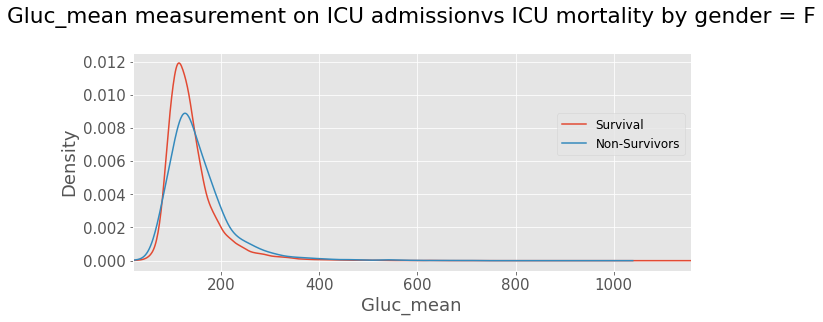

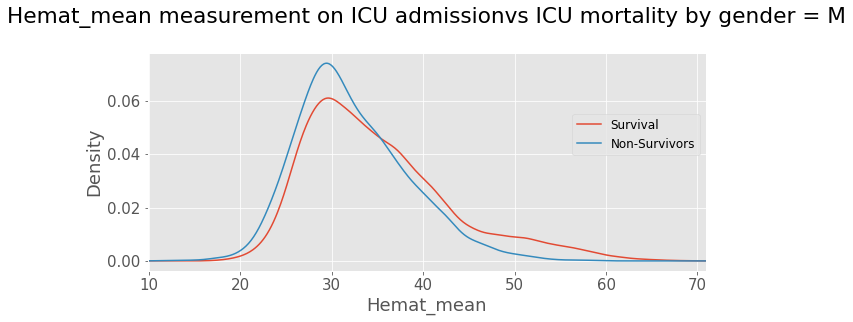

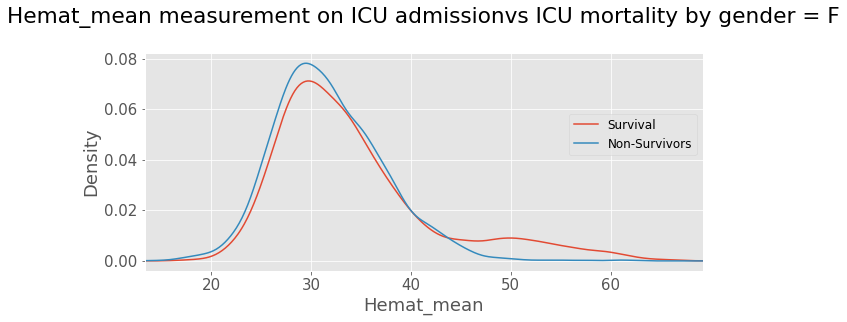

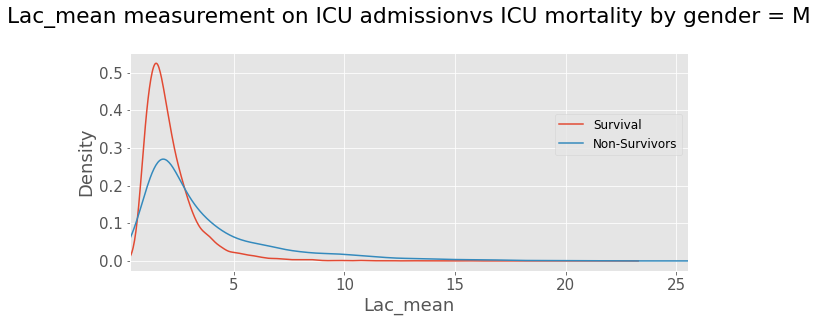

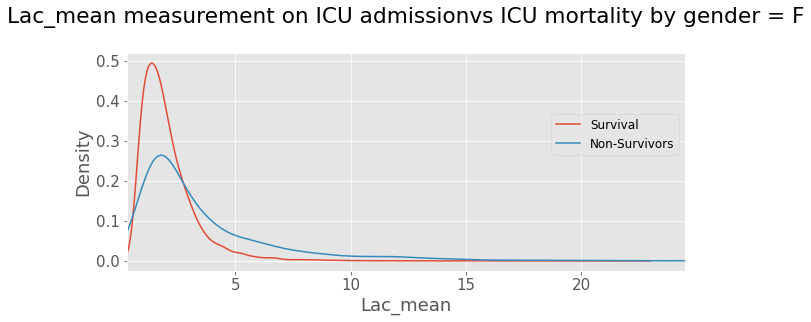

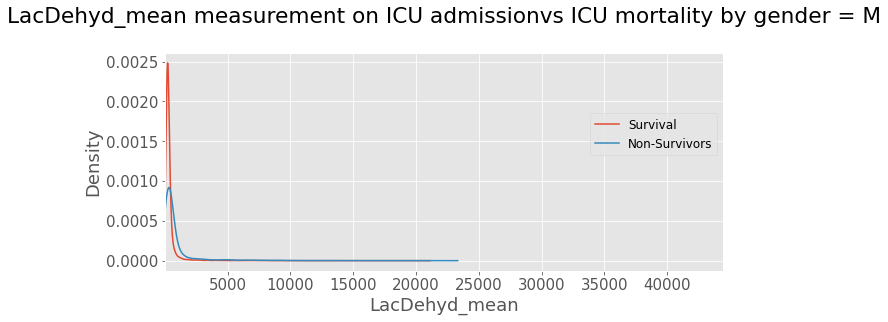

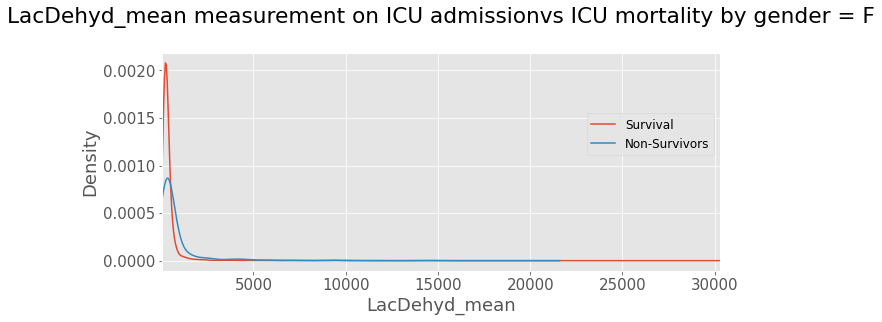

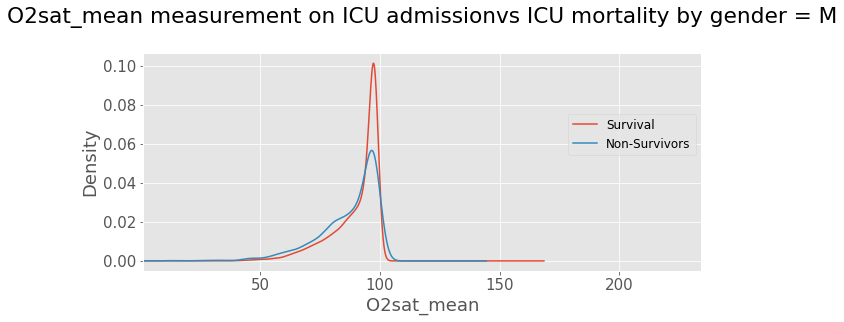

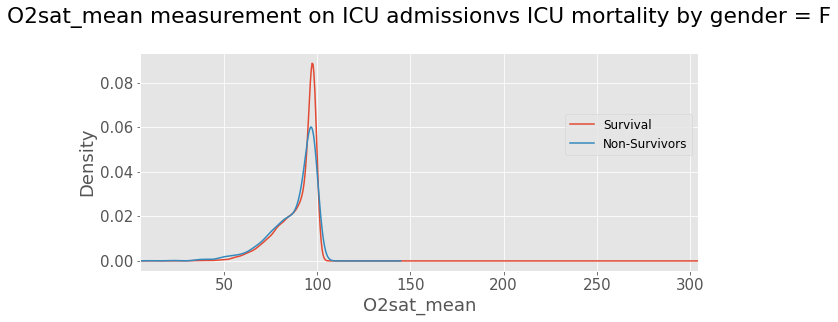

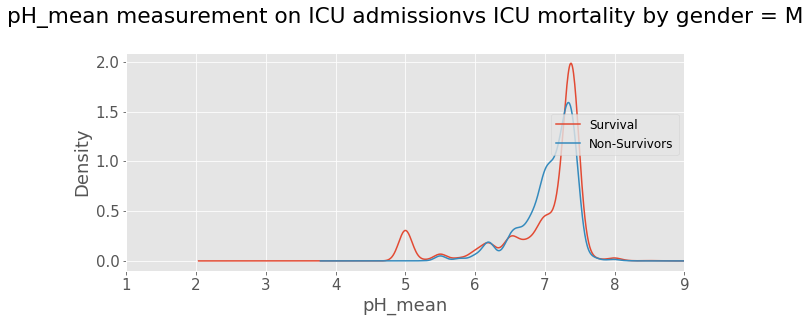

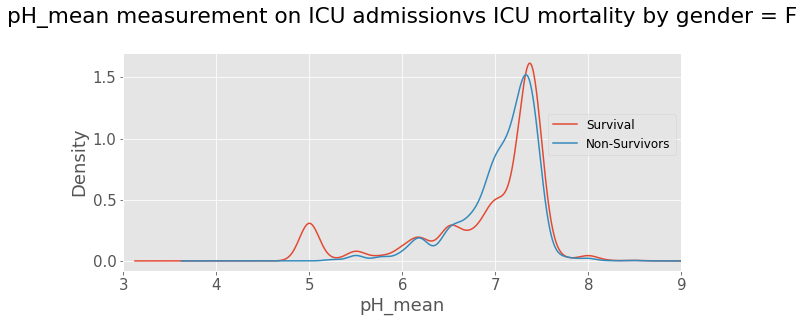

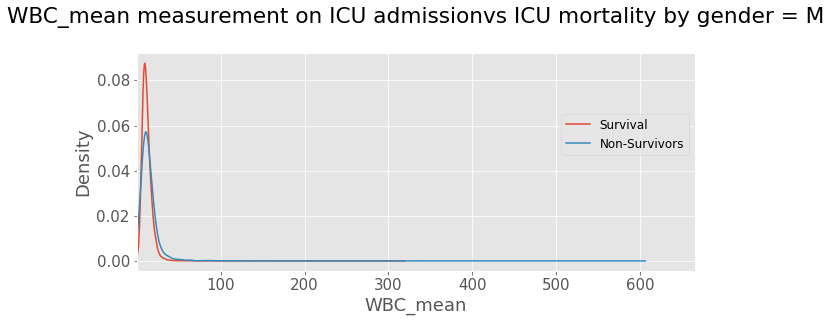

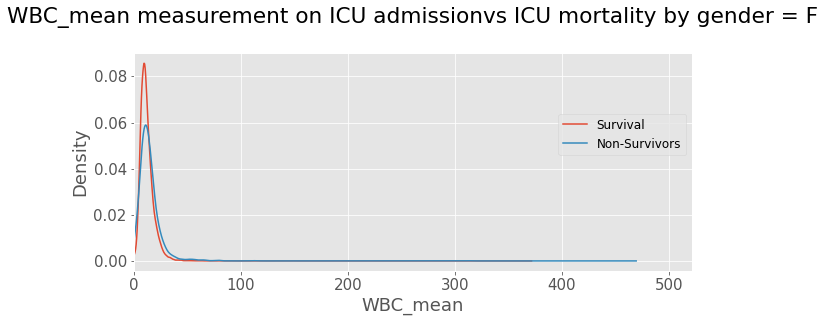

In [13]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['mean']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)

## REMOVE OUTLIER DATA POINTS 

In [14]:
names_dict = {}
suffix = '_outliers'

# SETTING OUTLIER DATA POINTS TO NAN FOR REMOVAL USING DROPNA()
for calc in calc_dict.keys():
    frame = calc_dict[calc]
    for col in frame.keys():
    # plot
    # print col
        dummy = frame[col]
        col2 = dummy.columns[0]
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)
        Q1 = np.percentile(dummy[col2].dropna(), 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(dummy[col2].dropna(), 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)
        names_dict[col+suffix] = dummy[~((dummy[col2] >= Q1 - step) & (dummy[col2] <= Q3 + step))].index
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
        dummy.loc[names_dict[col+suffix], col2] = np.NaN
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)




In [15]:
names_dict[col+suffix]

Int64Index([], dtype='int64', name='icustay_id')

In [16]:
dummy

,WBC_abnflag,hospital_expire_flag,gender
icustay_id,,,
200001,1.0,0,F
200003,1.0,0,M
200006,1.0,0,M
200007,1.0,0,M
200009,1.0,0,F
...,...,...,...
299993,1.0,0,M
299994,1.0,0,F
299995,1.0,0,M


## PLOT DATA WITH OUTLIERS REMOVED

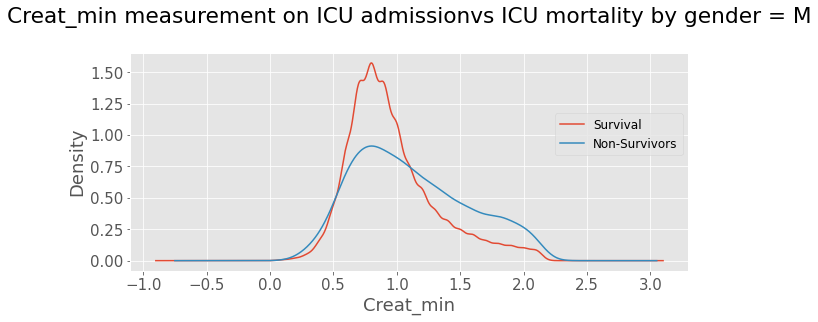

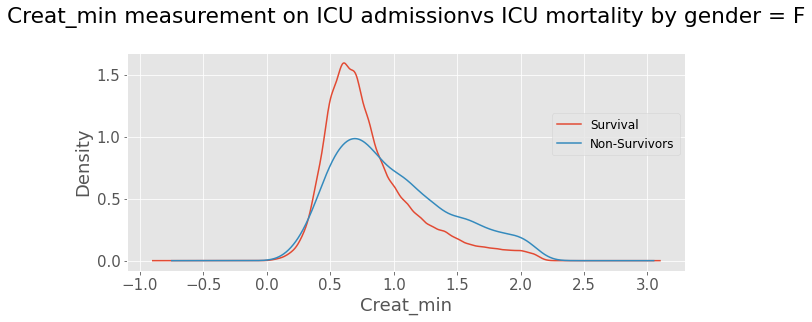

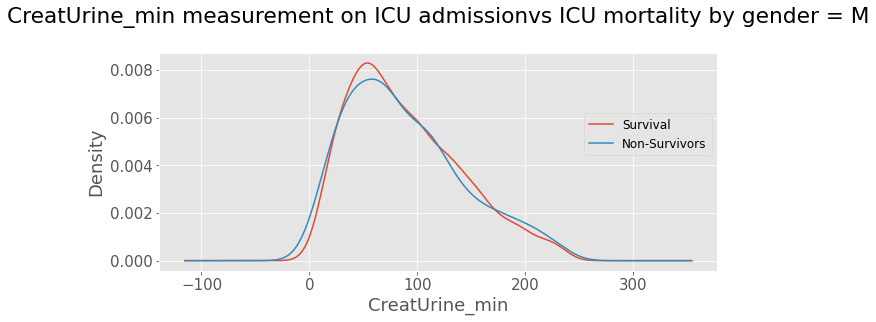

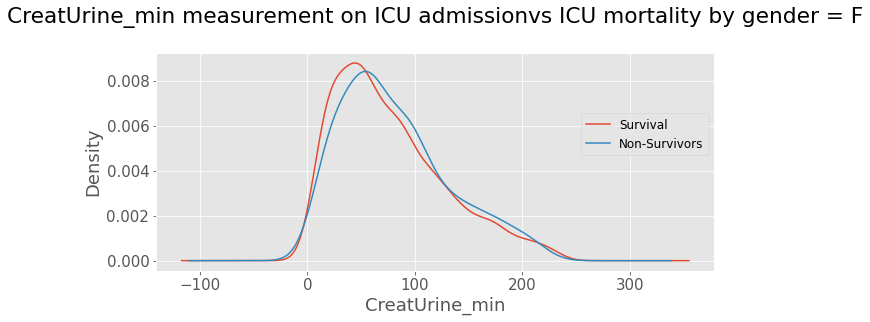

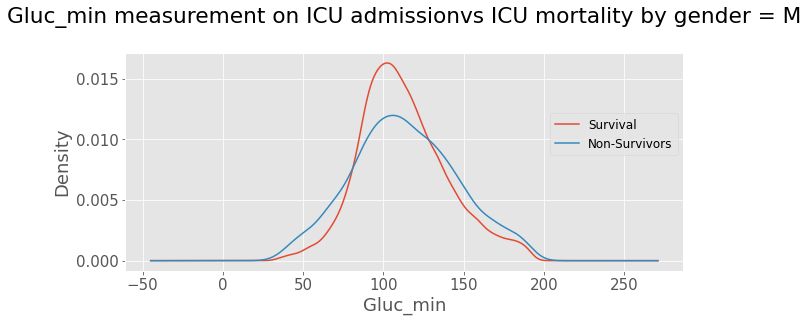

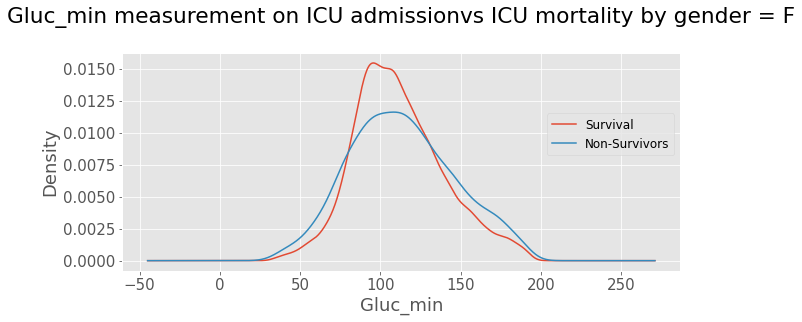

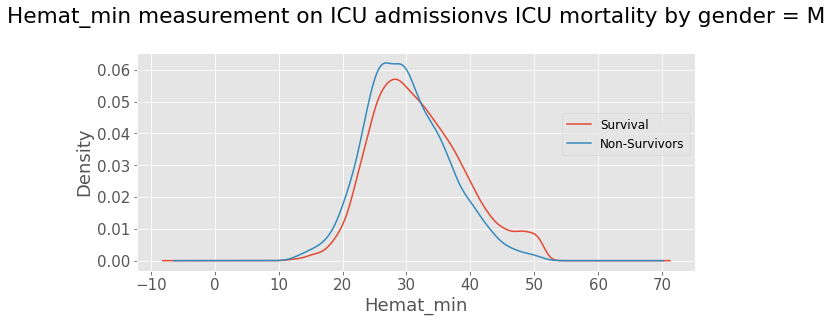

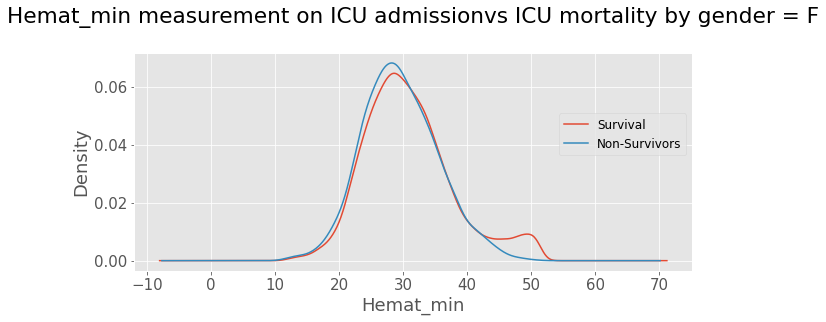

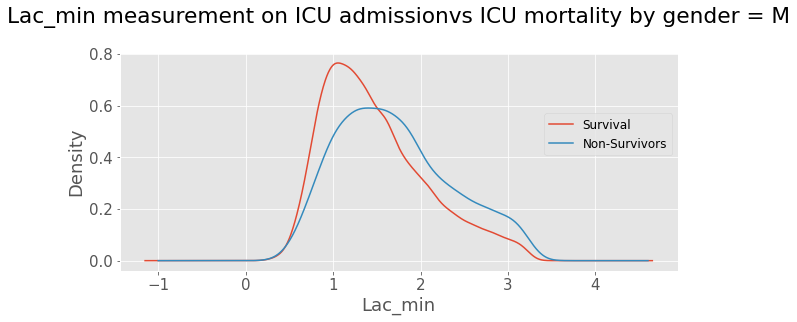

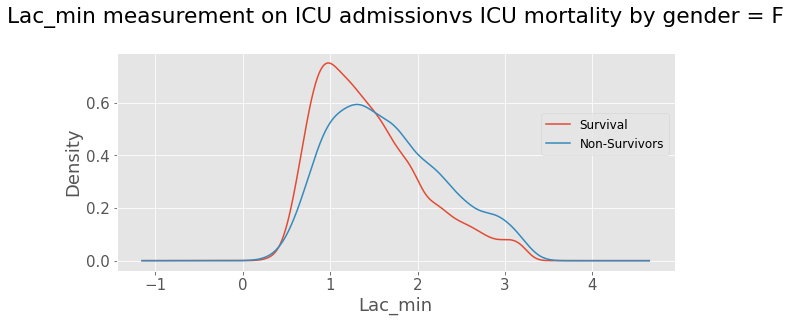

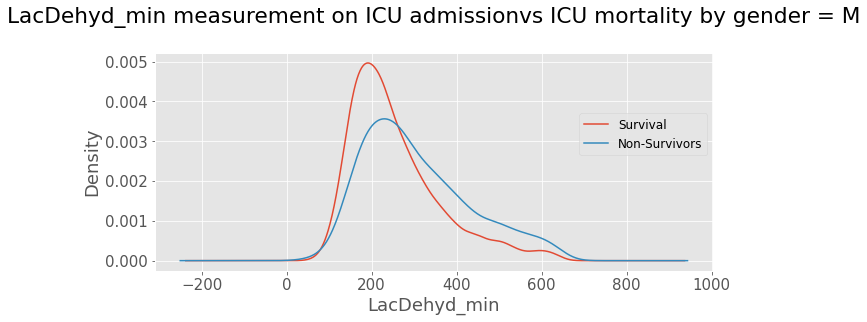

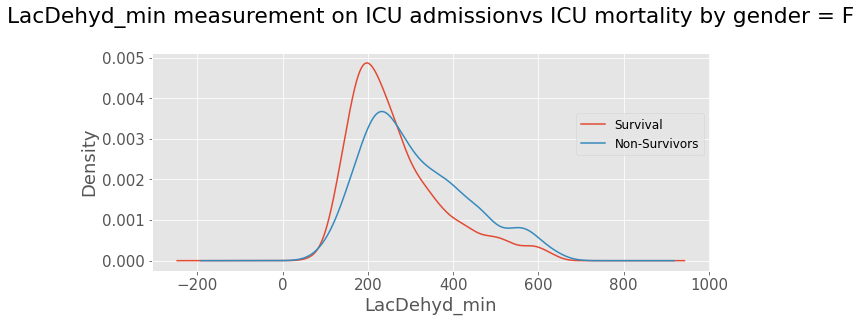

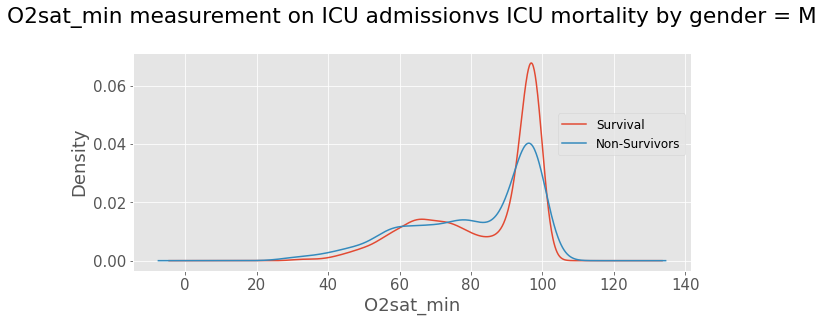

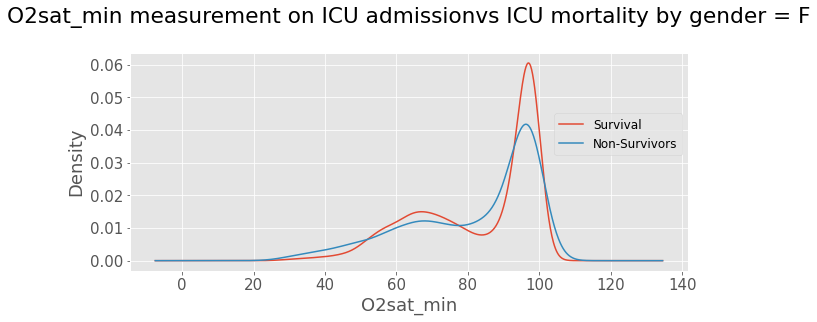

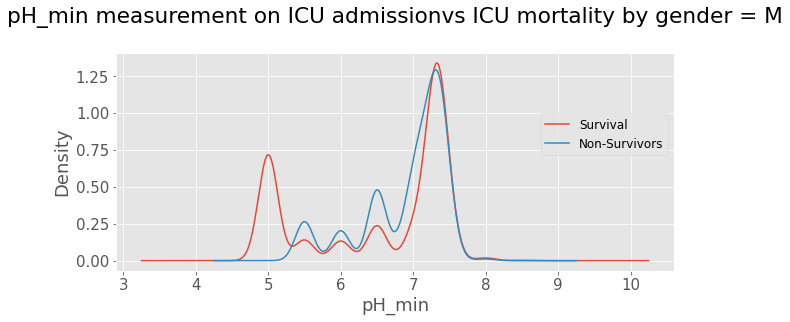

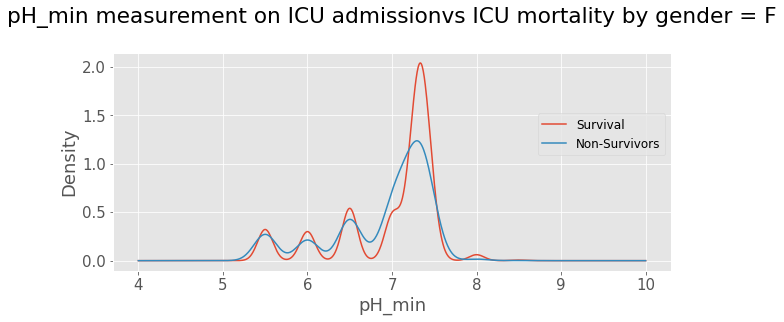

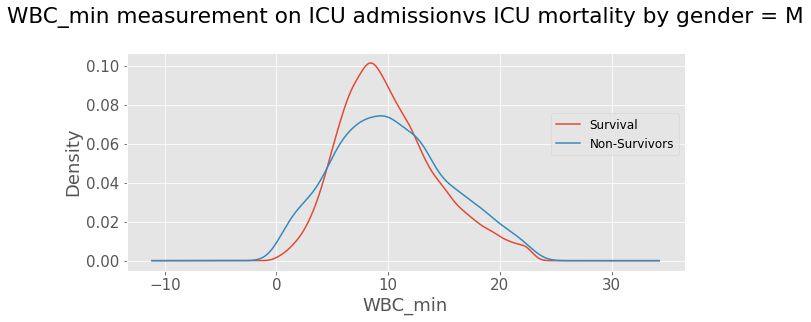

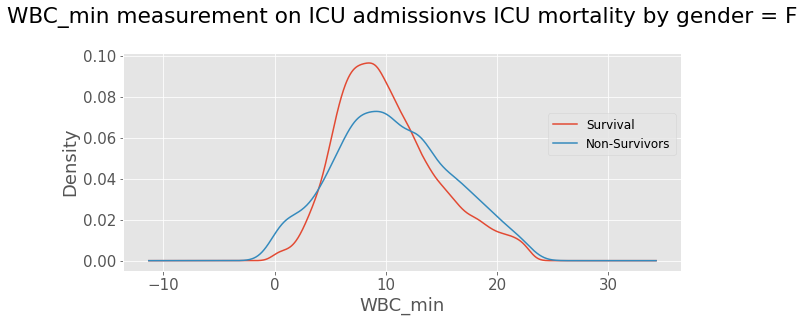

In [17]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['min']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(0.75,0.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        #plt.xlim(minlim, maxlim)

## MERGE INDIVIDUAL DATAFRAMES INTO SINGLE FRAME

In [18]:
# MERGING INDIVIDUAL CALCULATED FRAMES INTO A SINGLE DATAFRAMEs
lab_events_data_df2 = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first')
lab_events_data_df3 = lab_events_data_df2.drop(['label', 'charttime', 'valuenum', 'flag'], axis = 1)
lab_events_data_df3.set_index(['icustay_id'], inplace = True)

for calc_key in calc_dict.keys():
    print("merging {} dataframe".format(calc_key))
    for col_key in calc_dict[calc_key].keys(): 
        col2 = calc_dict[calc_key][col_key]
        lab_events_data_df3 = lab_events_data_df3.merge(pd.DataFrame(calc_dict[calc_key][col_key][col_key]), left_index = True, 
                           right_index = True, how = 'left', sort = True)
        newcols = list(lab_events_data_df3.columns)
        newcols.pop()
        newcols.append(col_key)
        lab_events_data_df3.columns = newcols
display(lab_events_data_df3.shape)
display(lab_events_data_df3.head())
display(lab_events_data_df3.dtypes)
        
# OLD CODE


merging first dataframe
merging mean dataframe
merging med dataframe
merging std dataframe
merging skew dataframe
merging min dataframe
merging max dataframe
merging slope dataframe
merging delta dataframe
merging abnflag dataframe


(59798, 93)

,subject_id,gender,hospital_expire_flag,Creat_first,CreatUrine_first,Gluc_first,Hemat_first,Lac_first,LacDehyd_first,O2sat_first,...,WBC_delta,Creat_abnflag,CreatUrine_abnflag,Gluc_abnflag,Hemat_abnflag,Lac_abnflag,LacDehyd_abnflag,O2sat_abnflag,pH_abnflag,WBC_abnflag
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,714216,F,0,2.7,NaN,87.0,26.1,1.4,209.0,88.0,...,-0.1,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,1.0
200003,482489,M,0,0.9,NaN,110.0,34.2,5.1,191.0,96.0,...,NaN,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0
200006,203547,M,0,1.1,NaN,226.0,35.9,3.1,NaN,NaN,...,NaN,0.0,NaN,1.0,1.0,1.0,NaN,NaN,0.0,1.0
200007,377653,M,0,0.9,NaN,NaN,44.4,NaN,NaN,NaN,...,3.3,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
200009,540204,F,0,0.5,NaN,91.0,30.3,0.7,NaN,98.0,...,0.5,0.0,NaN,NaN,1.0,1.0,NaN,0.0,1.0,1.0


subject_id                int64
gender                   object
hospital_expire_flag      int64
Creat_first             float64
CreatUrine_first        float64
                         ...   
Lac_abnflag             float64
LacDehyd_abnflag        float64
O2sat_abnflag           float64
pH_abnflag              float64
WBC_abnflag             float64
Length: 93, dtype: object

In [19]:
lab_events_data_df3.columns

Index(['subject_id', 'gender', 'hospital_expire_flag', 'Creat_first',
       'CreatUrine_first', 'Gluc_first', 'Hemat_first', 'Lac_first',
       'LacDehyd_first', 'O2sat_first', 'pH_first', 'WBC_first', 'Creat_mean',
       'CreatUrine_mean', 'Gluc_mean', 'Hemat_mean', 'Lac_mean',
       'LacDehyd_mean', 'O2sat_mean', 'pH_mean', 'WBC_mean', 'Creat_med',
       'CreatUrine_med', 'Gluc_med', 'Hemat_med', 'Lac_med', 'LacDehyd_med',
       'O2sat_med', 'pH_med', 'WBC_med', 'Creat_std', 'CreatUrine_std',
       'Gluc_std', 'Hemat_std', 'Lac_std', 'LacDehyd_std', 'O2sat_std',
       'pH_std', 'WBC_std', 'Creat_skew', 'CreatUrine_skew', 'Gluc_skew',
       'Hemat_skew', 'Lac_skew', 'LacDehyd_skew', 'O2sat_skew', 'pH_skew',
       'WBC_skew', 'Creat_min', 'CreatUrine_min', 'Gluc_min', 'Hemat_min',
       'Lac_min', 'LacDehyd_min', 'O2sat_min', 'pH_min', 'WBC_min',
       'Creat_max', 'CreatUrine_max', 'Gluc_max', 'Hemat_max', 'Lac_max',
       'LacDehyd_max', 'O2sat_max', 'pH_max', 'WBC_max',

In [20]:
calc

'abnflag'

In [21]:
[x for x in lab_events_data_df3.columns if calc in x] 

['Creat_abnflag',
 'CreatUrine_abnflag',
 'Gluc_abnflag',
 'Hemat_abnflag',
 'Lac_abnflag',
 'LacDehyd_abnflag',
 'O2sat_abnflag',
 'pH_abnflag',
 'WBC_abnflag']

In [22]:
lab_events_data_df3.columns

Index(['subject_id', 'gender', 'hospital_expire_flag', 'Creat_first',
       'CreatUrine_first', 'Gluc_first', 'Hemat_first', 'Lac_first',
       'LacDehyd_first', 'O2sat_first', 'pH_first', 'WBC_first', 'Creat_mean',
       'CreatUrine_mean', 'Gluc_mean', 'Hemat_mean', 'Lac_mean',
       'LacDehyd_mean', 'O2sat_mean', 'pH_mean', 'WBC_mean', 'Creat_med',
       'CreatUrine_med', 'Gluc_med', 'Hemat_med', 'Lac_med', 'LacDehyd_med',
       'O2sat_med', 'pH_med', 'WBC_med', 'Creat_std', 'CreatUrine_std',
       'Gluc_std', 'Hemat_std', 'Lac_std', 'LacDehyd_std', 'O2sat_std',
       'pH_std', 'WBC_std', 'Creat_skew', 'CreatUrine_skew', 'Gluc_skew',
       'Hemat_skew', 'Lac_skew', 'LacDehyd_skew', 'O2sat_skew', 'pH_skew',
       'WBC_skew', 'Creat_min', 'CreatUrine_min', 'Gluc_min', 'Hemat_min',
       'Lac_min', 'LacDehyd_min', 'O2sat_min', 'pH_min', 'WBC_min',
       'Creat_max', 'CreatUrine_max', 'Gluc_max', 'Hemat_max', 'Lac_max',
       'LacDehyd_max', 'O2sat_max', 'pH_max', 'WBC_max',

In [23]:
boolean_cols = [
    
    
]

In [24]:
lab_events_data_df3['Creat_abnflag'].head(25).fillna(0).astype(int)

icustay_id
200001    1
200003    0
200006    0
200007    0
200009    0
200010    0
200011    1
200012    0
200014    0
200016    0
200017    0
200018    0
200019    0
200020    0
200021    0
200023    0
200024    1
200025    0
200028    0
200029    0
200030    1
200031    0
200033    0
200034    0
200035    0
Name: Creat_abnflag, dtype: int64

In [25]:
lab_events_data_df3['Creat_abnflag'].head(25).apply(lambda x: 1 if x==1.0 else 0)

icustay_id
200001    1
200003    0
200006    0
200007    0
200009    0
200010    0
200011    1
200012    0
200014    0
200016    0
200017    0
200018    0
200019    0
200020    0
200021    0
200023    0
200024    1
200025    0
200028    0
200029    0
200030    1
200031    0
200033    0
200034    0
200035    0
Name: Creat_abnflag, dtype: int64

# Convert Boolean Cols to INT

In [26]:
cols = [x for x in lab_events_data_df3.columns if calc in x]
for col in cols: 
    lab_events_data_df3[col] = lab_events_data_df3[col].fillna(0).astype(int)

# Prior Versions Didn't Fully Leverage Interpolation
As Such, efforts below were made to found labs most commonly found together. 

## Looking for labs that are commonly missing together

In [27]:
# # ROUNDING DATA
# np.set_printoptions(precision=2)

# cols = [x for x in lab_events_data_df3.columns if calc in x] 
# cols.sort()
    
# header = lab_events_data_df3[cols]
# for col in header.columns:
#     header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
# display(lab_events_data_df3[cols].dropna().shape[0])

# display(header.corr().round(2))

## DISPLAY COLORMAP OF MISSING DATA

In [28]:
# commenting out for refinement. 
# very time consuming part of pre-processing. uncomment and run if you'd like to see the process. 


'''
# DISPLAY COLORMAP OF DATA 

for calc in calc_list:
    plt.figure(figsize= (30,30))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    
    header = data3[cols]
    for col in header.columns:
        max_val = -1000 #header[col].max()*100
        #header[col].replace(np.nan, max_val, inplace = True)
        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
    display(data3[cols].dropna().shape[0])
    missing = header.corr()
    display(missing[missing >= 0.4])
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

print "Complete"
'''

'\n# DISPLAY COLORMAP OF DATA \n\nfor calc in calc_list:\n    plt.figure(figsize= (30,30))\n    cols = [x for x in data3.columns if calc in x] \n    cols.sort()\n    \n    header = data3[cols]\n    for col in header.columns:\n        max_val = -1000 #header[col].max()*100\n        #header[col].replace(np.nan, max_val, inplace = True)\n        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)\n    display(data3[cols].dropna().shape[0])\n    missing = header.corr()\n    display(missing[missing >= 0.4])\n    plt.pcolor(header)\n    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)\n    plt.show()\n\nprint "Complete"\n'

## CREATE AUTOCORRELATION MATRIX FOR MISSING DATA

In [29]:
# #header.apply(lambda col: col.autocorr(lag = 1), axis = 0)
# # REPLACING NAN VALUES WITH 1 AND MEASUREMENTS WITH 0. PERFORMING CORRELATION BETWEEN COLUMNS TO DETERMINE WHICH 
# # VARIABLES ARE MOST LIKELY TO BE MISSING TOGETHER. THIS WILL HELP IN BLOCKING DATA FOR PROCESSES THAT REQUIRE DATA TO 
# # BE NAN FREE
# missing = lab_events_data_df3.copy()
# for col in missing.columns:
#     missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        
# monkey = missing.corr()
# monkey[monkey >= 0.4]

In [30]:
# DROPPING COLUMNS WHERE DATA IS SPARSE AND MISSING DATA DOES NOT CORRELATE WITH OTHER VARIABLES. 
# THESE DETERMINATIONS WERE MADE THROUGH OBSERVATIONS OF THE AFFINITY MAPS AND DROPNA().SHAPE[0] VALUES ABOVE 

# REMOVING ALL CREATURINE MEASURES
drop_cols = []
for item in lab_events_data_df3.columns: 
    if (('CreatUrine'in item) | ('LacDehyd' in item) | ('_skew' in item)):
        drop_cols.append(item)
#drop_cols

# DROP THE FOLLOWING MEASURES OF THE FOLLOWING VARIABLES
#drop_names = ['CreatUrine', 'LacDehyd', 'O2sat', 'Lac']
drop_names = ['O2sat', 'Lac']
drop_measures = ['_std', '_slope']
for name in drop_names:
    for ext in drop_measures:
        drop_cols.append(name + ext)
        
drop_cols
        

display(lab_events_data_df3.dropna().shape[0])
lab_events_data_df4 = lab_events_data_df3.drop(drop_cols, inplace = False, axis = 1)
display(lab_events_data_df4.dropna().shape[0])

print("Complete")

0

732

Complete


## COMBINING FRAMES AND DROPPING MISSING VALUES

In [ ]:
# # TO THIS POINT THE ICUSTAY_ID HAS BEEN USED AS THE INDEX OF THE DATAFRAME. 
# # TO USE THESE METHODS WE CREATE A PROPER INDEX


# # BREAKING UP VARIABLES SO THAT WE CAN DROP NAN VALUES AND STILL HAVE SUFFICIENT SAMPLES 
# # TO TRANSFORM AND DO FEATURE SELECTION / SCORING
# # WILL NEED TO MERGE LATER IN A WAY THAT PROVIDES ADEQUATE SAMPLES

# cols1 = [x for x in data4.columns if (('abnflag' not in x) & (('pH' in x) | ('Lac' in x) | ('O2sat' in x)))]
# cols2 = [x for x in data4.columns if (('abnflag' not in x) & (('Creat' in x) | ('Gluc' in x) | ('Hemat' in x) | ('WBC' in x)))]
# cols3 = [x for x in data4.columns if ('abnflag' in x)]

# header = ['hospital_expire_flag']
# for thing in header:
#     cols1.insert(0, thing)
#     cols2.insert(0, thing) 
#     cols3.insert(0, thing)
  

# #display(cols1)
# data4.replace([np.inf, -np.inf], np.nan, inplace = True)
# pHLacO2Sat_data = data4[cols1].dropna()
# print "pHLacO2Sat_data: Shape = "
# display(pHLacO2Sat_data.shape)                              

# CreatGlucHemWBC_data = data4[cols2].dropna()
# print "CreatGlucHemWBC_data: Shape = "
# display(CreatGlucHemWBC_data.shape)

# AbnFlag_data = data4[cols3].dropna()
# print "AbnFlag_data: Shape = "
# display(AbnFlag_data.shape)

       
# cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
# cat_frames = [AbnFlag_data]




In [31]:
lab_events_data_df4.replace([np.inf, -np.inf], np.nan, inplace = True)

In [32]:
lab_events_data_df4.columns

Index(['subject_id', 'gender', 'hospital_expire_flag', 'Creat_first',
       'Gluc_first', 'Hemat_first', 'Lac_first', 'O2sat_first', 'pH_first',
       'WBC_first', 'Creat_mean', 'Gluc_mean', 'Hemat_mean', 'Lac_mean',
       'O2sat_mean', 'pH_mean', 'WBC_mean', 'Creat_med', 'Gluc_med',
       'Hemat_med', 'Lac_med', 'O2sat_med', 'pH_med', 'WBC_med', 'Creat_std',
       'Gluc_std', 'Hemat_std', 'pH_std', 'WBC_std', 'Creat_min', 'Gluc_min',
       'Hemat_min', 'Lac_min', 'O2sat_min', 'pH_min', 'WBC_min', 'Creat_max',
       'Gluc_max', 'Hemat_max', 'Lac_max', 'O2sat_max', 'pH_max', 'WBC_max',
       'Creat_slope', 'Gluc_slope', 'Hemat_slope', 'pH_slope', 'WBC_slope',
       'Creat_delta', 'Gluc_delta', 'Hemat_delta', 'Lac_delta', 'O2sat_delta',
       'pH_delta', 'WBC_delta', 'Creat_abnflag', 'Gluc_abnflag',
       'Hemat_abnflag', 'Lac_abnflag', 'O2sat_abnflag', 'pH_abnflag',
       'WBC_abnflag'],
      dtype='object')

In [39]:
X = lab_events_data_df4[lab_events_data_df4.columns[3:]]
# imp_iter = IterativeImputer(missing_values = np.nan, max_iter=100, add_indicator=True)
imp_iter = SimpleImputer(missing_values = np.nan, add_indicator=False)
imp_iter.fit(X)
imputed_data_df = imp_iter.transform(X)


In [40]:
imputed_data_df.shape

(59798, 59)

In [41]:
lab_events_data_df4[lab_events_data_df4.columns[3:]] = imputed_data_df


## CONVERTING CONTINUOUS TO CATEGORICAL VARIABLES

In [43]:
lab_events_data_df4.columns

Index(['subject_id', 'gender', 'hospital_expire_flag', 'Creat_first',
       'Gluc_first', 'Hemat_first', 'Lac_first', 'O2sat_first', 'pH_first',
       'WBC_first', 'Creat_mean', 'Gluc_mean', 'Hemat_mean', 'Lac_mean',
       'O2sat_mean', 'pH_mean', 'WBC_mean', 'Creat_med', 'Gluc_med',
       'Hemat_med', 'Lac_med', 'O2sat_med', 'pH_med', 'WBC_med', 'Creat_std',
       'Gluc_std', 'Hemat_std', 'pH_std', 'WBC_std', 'Creat_min', 'Gluc_min',
       'Hemat_min', 'Lac_min', 'O2sat_min', 'pH_min', 'WBC_min', 'Creat_max',
       'Gluc_max', 'Hemat_max', 'Lac_max', 'O2sat_max', 'pH_max', 'WBC_max',
       'Creat_slope', 'Gluc_slope', 'Hemat_slope', 'pH_slope', 'WBC_slope',
       'Creat_delta', 'Gluc_delta', 'Hemat_delta', 'Lac_delta', 'O2sat_delta',
       'pH_delta', 'WBC_delta', 'Creat_abnflag', 'Gluc_abnflag',
       'Hemat_abnflag', 'Lac_abnflag', 'O2sat_abnflag', 'pH_abnflag',
       'WBC_abnflag'],
      dtype='object')

In [42]:
# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL

def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    
#cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
#cat_frames = [AbnFlag_data]
    
CreatGlucHemWBC_cat_data = CreatGlucHemWBC_data.copy()
pHLacO2Sat_cat_data = pHLacO2Sat_data.copy()

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]

for frame in cont_cat_frames:
    frame_stats = frame.describe()
    for col in frame.columns[1:]:
        Q1 = frame_stats[col].loc['25%']
        Q2 = frame_stats[col].loc['50%']
        Q3 = frame_stats[col].loc['75%']
        frame[col] = frame[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))

pHLacO2Sat_cat_data.head()        




NameError: name 'CreatGlucHemWBC_data' is not defined

## COMBINING FRAMES

In [ ]:

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]


pHLacO2Sat_dummies = pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[:1]].merge(pd.get_dummies(pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
CreatGlucHemWBC_dummies = CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[:1]].merge(pd.get_dummies(CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
                       
display(pHLacO2Sat_dummies.head())
display(CreatGlucHemWBC_dummies.head())


## CONVERT DATA TO DUMMY VARIABLES, RECOMBINE, SELECT BEST FEATURES WRITE TO FILE

In [ ]:
dummy_frames = [CreatGlucHemWBC_dummies, pHLacO2Sat_dummies, AbnFlag_data]
dummy_frame_filenames = ['Lab_CreatGlucHemWBC_Features', 'Lab_pHLacO2Sat_Features', 'Lab_AbnFlag_Features']
dummy_dict = dict(zip(dummy_frame_filenames, dummy_frames))

for name, frame in dummy_dict.iteritems():
    print "{}      {}".format(name, frame.shape[0])

# CREATGLUC ETC HAS ONLY 874 SAMPLES AND SO WON'T BE HELPFUL. 

root = os.getcwd() + '/features/'

for name, frame in dummy_dict.iteritems():#frame = cat_dummy_frames[0]
    X_continuous = frame[frame.columns[1:]]
    y = frame['hospital_expire_flag']
    #display(X_continuous.shape)
    #display(y.shape)
    # ONLY PASSING FRAMES W/ > 5000 ICUSTAYS
    if y.shape[0] > 3000:
        
        # SELECT K BEST FEATURES BASED ON CHI2 SCORES
        selector = SelectKBest(score_func = chi2, k = 'all')
        selector.fit(X_continuous, y)
        p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X_continuous.columns)
        scores = pd.Series(selector.scores_, name = 'scores', index = X_continuous.columns)
        cont_features_df = pd.concat([p_vals, scores], axis = 1)
        cont_features_df.sort_values(by ='scores', ascending = False, inplace = True)
        best_features = frame[cont_features_df[cont_features_df.p_values < .001].index]
        frame = pd.DataFrame(y).merge(best_features, left_index = True, right_index = True, 
                       how = 'left', sort = True)
        print "{}     {}".format(name, frame.shape)
        frame.to_csv(root + name + '.csv')
        cont_features_df[cont_features_df.p_values < .001].to_csv(root + name + 'Scores.csv')